In [2]:
import sys
sys.path.append('../utils')
from rio_tools import reproject_arr_to_match_profile, get_cropped_profile
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from pprint import pprint

The main goal of this notebook is to illustrate how to coregister geospatial SAR products for environmental analysis and monitoring.


## Rasterio


We are going to illustrate how to use `rasterio` for Global Information System mapping (GIS, for short) of raster data. `Rasterio` is a popular python library for manipulating georeferenced rasters. This library is very well maintained and constantly being [improved](https://github.com/mapbox/rasterio/graphs/contributors). Additionally, there is healthy activity related to `rasterio` on [GIS stack-exchange](https://gis.stackexchange.com/search?q=rasterio) and an excellent quickstart [tutorial](https://rasterio.readthedocs.io/en/stable/quickstart.html). Not everything can be covered here, but more details and information can easily be found searching the `rasterio` github, rasterio [documentation](https://rasterio.readthedocs.io/en/stable/), and the GIS stack-exchange.


# Raster data (GeoTIFF)

Scenario: we have a stack of SAR images and we want to use these images to do some form of environmental analysis such as change detection.

We need to be able to have a single reference frame so that:

1. Each image has the same size
2. The images have the same resolution.
3. The pixel position $(i, j)$ refers to the same position on the map for *all images* in our stack.

Frequently, these stipulations mean that all the images in are stack are *coregistered*. In the `data` directory, we have two images that are not coregistered. Not only do the images have different different coverage areas, but different resolutions and sizes. View them yourselves in QGIS.

All the images we use in this tutorial are [geotiff](https://en.wikipedia.org/wiki/GeoTIFF). Geospatial rasters not only stores the raster image, but also the geospatial metadata such as the image extents, resolution, etc so they can be easily converted when needed. There are numerous other raster [formats](https://gdal.org/drivers/raster/index.html), all but `netcdf` is supported in `rasterio`.

# Before Diving in...

*Look at the images in `/data` in qgis!*

# Inspecting the Data

Let's get the filepaths from the data directory.

In [3]:
data_dir = Path('data')
tifs = list(data_dir.glob('*.tif'))
tifs

[PosixPath('data/alos_coh_hh.tif'),
 PosixPath('data/alos_backscatter_hh.tif'),
 PosixPath('data/alos_backscatter_hv.tif'),
 PosixPath('data/alos_coh_hv.tif')]

We can select the files that are backscatter using python string functions.

In [4]:
backscatter_tifs = sorted(list(filter(lambda path: 'backscatter' in path.name, tifs)))
backscatter_tifs

[PosixPath('data/alos_backscatter_hh.tif'),
 PosixPath('data/alos_backscatter_hv.tif')]

Same for coherence.

In [5]:
coherence_tifs = sorted(list(filter(lambda path: 'coh' in path.name, tifs)))
coherence_tifs

[PosixPath('data/alos_coh_hh.tif'), PosixPath('data/alos_coh_hv.tif')]

## Image Metadata

We open files using [`rasterio`](https://rasterio.readthedocs.io/en/stable/). Note the "pythonic" way of opening files - within the `with` statement block the raster object is read and automatically closed once the end of the block is reached.

In [6]:
with rasterio.open(coherence_tifs[0]) as ds:
    coh_hh = ds.read()
    coh_profile = ds.profile

The relevant metadata for rasterio is contained in a profile as a python [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries). For those familiar with `gdal`, this is a concise form of `gdalinfo`.

In [7]:
pprint(coh_profile)

{'count': 1,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 500,
 'interleave': 'band',
 'nodata': nan,
 'tiled': False,
 'transform': Affine(0.0002777777777777778, 0.0, 9.436944444444444,
       0.0, -0.0002777777777777778, 0.6111111111111109),
 'width': 500}


In [8]:
print('This is the crs: ', coh_profile['crs'])
print('This is the origin and resolution data: ', coh_profile['transform'])
print('This is the datatype of the raster: ', coh_profile['dtype'])
print('This is how many bands are in the raster', coh_profile['count'])

This is the crs:  EPSG:4326
This is the origin and resolution data:  | 0.00, 0.00, 9.44|
| 0.00,-0.00, 0.61|
| 0.00, 0.00, 1.00|
This is the datatype of the raster:  float32
This is how many bands are in the raster 1


The "transform" above is an object from the [`Affine`](https://github.com/sgillies/affine) library. It's very handy when manipulating geodata - we will briefly discuss this affine transformation in a later section of this notebook.


### Image Formats

Spatial dimensions and channels can be ordered in various ways. Let our image have spatial dimensions $M \times N$, that is M pixels in the vertical axis and $N$ in the horizontal.

+ BIP - band interleaved by pixel - (# of bands/channels) $\times M \times N$ - this is how `gdal` and `rasterio` store raster data
+ BSQ - band sequential - $M \times N \times$ (# of bands/channels) - how `numpy` stores raster data
+ BIL - band interleaved by line - $M \times$ (# of bands/channels) $\times N$ - not releveant but included for completeness.

Indeed, rasterio's images are BIP as illustrated below:

In [9]:
print('Rasterio shape: ', coh_hh.shape)

Rasterio shape:  (1, 500, 500)


We can view the single band in matplotlib as a matrix $M \times N$, but BIP images are not understood by matplotlib. Below, we select the first band to display.

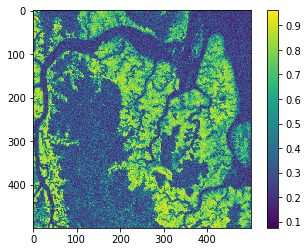

In [10]:
plt.imshow(coh_hh[0, ...])
plt.colorbar()

# Reprojecting to Backscatter Reference Frame

The backscatter images and the coherence images have different reference frames. We select the backscatter reference frame and will reproject the coherence images into that reference frame - we could have easily done the reverse namely reprojecting the backscatter images to the coherence reference frame.

In [11]:
with rasterio.open(backscatter_tifs[0]) as ds:
    backscatter_hh = ds.read()
    backscatter_profile = ds.profile

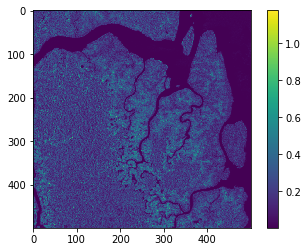

In [12]:
plt.imshow(backscatter_hh[0, ...])
plt.colorbar()

What's different in the profiles below?

In [13]:
pprint(coh_profile)

{'count': 1,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 500,
 'interleave': 'band',
 'nodata': nan,
 'tiled': False,
 'transform': Affine(0.0002777777777777778, 0.0, 9.436944444444444,
       0.0, -0.0002777777777777778, 0.6111111111111109),
 'width': 500}


In [14]:
pprint(backscatter_profile)

{'compress': 'packbits',
 'count': 1,
 'crs': CRS.from_epsg(32732),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 500,
 'interleave': 'band',
 'nodata': 0.0,
 'tiled': False,
 'transform': Affine(30.0, 0.0, 549563.875,
       0.0, -30.0, 10067362.0),
 'width': 500}


We have a function that shortens this from the [docs](https://rasterio.readthedocs.io/en/stable/topics/reproject.html).

In [15]:
coh_hh_r, coh_hh_profile = reproject_arr_to_match_profile(coh_hh, 
                                                          coh_profile, 
                                                          backscatter_profile, 
                                                          resampling='bilinear')

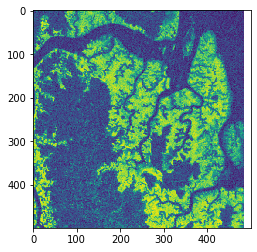

In [16]:
plt.imshow(coh_hh_r[0,...])

We now write this image to disk.

In [17]:
out = Path('out')
out.mkdir(exist_ok=True)
with rasterio.open(out/coherence_tifs[0].name, 'w', **coh_hh_profile) as ds:
    ds.write(coh_hh_r)

# Excercise 1

Reproject the HV coherence image into the backscatter image.

In [18]:
## Answer

with rasterio.open(coherence_tifs[1]) as ds:
    coh_hv = ds.read()
    coh_profile = ds.profile

In [19]:
## Answer

coh_hv_r, coh_hv_profile = reproject_arr_to_match_profile(coh_hv, coh_profile, backscatter_profile, resampling='bilinear')
with rasterio.open(out/coherence_tifs[1].name, 'w', **coh_hv_profile) as ds:
    ds.write(coh_hv_r)

# Creating A `nodata` Mask

We need a consistent nodata mask for the images we reprojected above.

In [20]:
reprojected_tifs = list(out.glob('*.tif'))
reprojected_tifs

[PosixPath('out/alos_coh_hh.tif'), PosixPath('out/alos_coh_hv.tif')]

In [21]:
tifs_for_cube = reprojected_tifs + backscatter_tifs

In [22]:
def open_one_single_band_image(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
    return band

bands = list(map(open_one_single_band_image, tifs_for_cube))
# this is the same as the code below - uncomment if you like
# bands = [open_one_single_band_image(path) for path in tifs_for_cube]

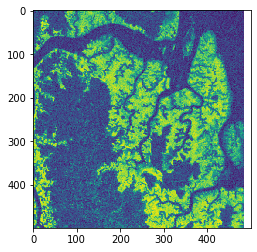

In [22]:
plt.imshow(bands[0])

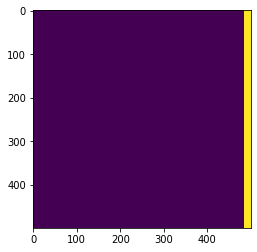

In [23]:
# Method 1

nodata_mask = np.zeros(bands[0].shape, dtype=bool)
for k in range(len(bands)):
    # the "|" means or entrywise
    nodata_mask = (nodata_mask | np.isnan(bands[k]))
plt.imshow(nodata_mask)

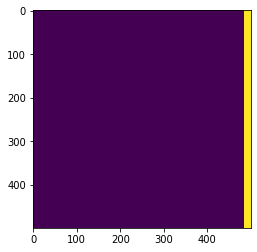

In [24]:
# Method 2 - more functional

nodata_bands = list(map(np.isnan, bands))
nodata_mask = np.logical_or.reduce(nodata_bands)
plt.imshow(nodata_mask)

# Cropping an Image

Here is how you can crop the images and remove the nodata areas using `get_cropped_profile`.

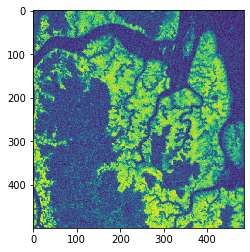

In [25]:
max_x = np.argmax(nodata_mask[0,:])
sy = np.s_[:]
sx = np.s_[:max_x]
plt.imshow(bands[0][sy, sx])

In [26]:
reference_profile = get_cropped_profile(backscatter_profile, sx, sy)
pprint(reference_profile)

{'compress': 'packbits',
 'count': 1,
 'crs': CRS.from_epsg(32732),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 500,
 'interleave': 'band',
 'nodata': 0.0,
 'tiled': False,
 'transform': Affine(30.0, 0.0, 549563.875,
       0.0, -30.0, 10067362.0),
 'width': 484}


In [27]:
def crop_one(band):
    band_r, _ = reproject_arr_to_match_profile(band, 
                                               backscatter_profile, 
                                               reference_profile, 
                                               resampling='nearest')
    return band_r

In [28]:
bands_c = list(map(crop_one, bands))
len(bands_c)

4

In [29]:
bands_c[-1].shape

(1, 500, 484)

Write these bands to a file.

In [30]:
cropped_dir = Path('cropped')
cropped_dir.mkdir(exist_ok=True)

def write_one(data):
    band, name = data
    with rasterio.open(cropped_dir/name, 'w', **reference_profile) as ds:
        ds.write(band)
    return cropped_dir/name

In [31]:
names = list(map(lambda x: x.name, tifs_for_cube))
data = list(zip(bands_c, names))
list(map(write_one, data))

[PosixPath('cropped/alos_coh_hh.tif'),
 PosixPath('cropped/alos_coh_hv.tif'),
 PosixPath('cropped/alos_backscatter_hh.tif'),
 PosixPath('cropped/alos_backscatter_hv.tif')]

# A Digression into Transforms

Transforms control the *extents* and *resolution* of our coordinate reference frame. They are encoded as [affine transformations](https://en.wikipedia.org/wiki/Transformation_matrix#Affine_transformations) and are implemented in python using the [affine](https://github.com/sgillies/affine) library, which includes routines for evaluating the affine transformations on pixel coordinates $(i, j)$.

The affine transformation $T$: pixel coordinates $\to$ georferenced coordinates as a matrix multiplication, namely, $T \cdot (i, j)$ is the georeference point of the pixel in position $(x, y)$ on the map. For example, we can perform this using the coherence images lat, lon reference frame from above. 

In [32]:
with rasterio.open(coherence_tifs[0]) as ds:
    trans = ds.transform

In [33]:
from geopy import distance

x0, y0 = trans * (0, 0)
x1, y0 = trans * (1, 0)
x0, y1 = trans * (0, 1)

# these are the georeferenced coordinates
x0, y0, x1, y1

(9.436944444444444, 0.6111111111111109, 9.437222222222221, 0.6108333333333331)

`x0, y0` is the upper left corner of the image.

# Exercise 2

Use the transform above to determine how big the upper left resolution frame is.

Use `distance.distance` from the geopy library as explained [here](https://geopy.readthedocs.io/en/stable/#module-geopy.distance).

Note, their function takes tuples that are in (lat, lon), i.e. (y, x). Here is the height in meters along the first resolution cell.

In [34]:
distance.distance((y0, x0), (y1, x0)).meters

30.71511168703892

Try finding the width.

In [35]:
## Answer

distance.distance((y0, x0), (y0, x1)).meters

30.9203336956487

# Acknowledgements

We gratefully and humbly acknowledge JAXA for the use of ALOS-2 data to generate a coherence image over Mondah, Gabon generated using ISCE2.

We are grateful to the ASF for providing easy access to ALOS-1 radiometrically and terrain corrected tiles over Mondah and Ko Panyi.

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.